In [14]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import torch.nn.functional as F
import seaborn as sns
from random import randint
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
    resize_to_orig,
)

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        y = idx
        x_aug = augment_sample(x_orig)
        x_prime = augment_sample_random_mask(
            x_orig, random_mask_prob=self.mask_prob
        )
        return x_orig, x, masked_x, y, x_aug, x_prime

In [17]:
model = torch.load(
    "simclr_decoder.pth", weights_only=False, map_location=DEVICE
)
model.eval()

BATCH_SIZE = 100
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Grab a batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x_orig = batch[0].to(DEVICE)
x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([100, 5, 144, 72])


In [19]:
with torch.no_grad():
    _, recon_x = model(x)
    _, recon_masked_x = model(masked_x)

print(F.mse_loss(recon_masked_x, x_orig))
print(F.mse_loss(recon_x, x_orig))

tensor(0.3509)
tensor(0.2627)


In [20]:
print(recon_x.shape)
x_temp = x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
recon_x_temp = (
    recon_x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
)

masked_x_temp = (
    masked_x[:, 0, :, :]
    .unsqueeze(1)
    .squeeze(0)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)
recon_masked_x_temp = (
    recon_masked_x[:, 0, :, :]
    .unsqueeze(1)
    .squeeze(0)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)

x_orig_temp = (
    x_orig[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
)

print(F.mse_loss(recon_masked_x, x_orig))
print(F.mse_loss(recon_x, x_orig))

torch.Size([100, 5, 64, 32])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

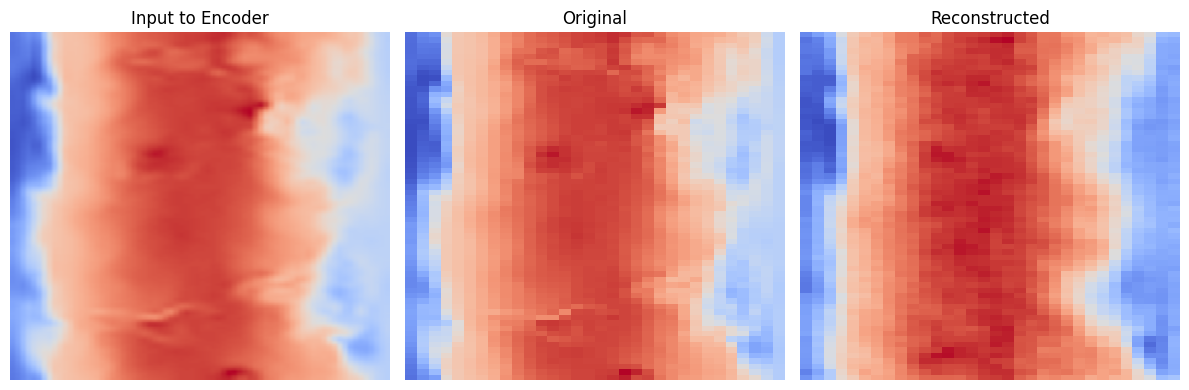

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_temp, cmap="coolwarm", aspect="auto")
axs[0].set_title("Input to Encoder")
axs[0].axis("off")

axs[1].imshow(x_orig_temp, cmap="coolwarm", aspect="auto")
axs[1].set_title("Original")
axs[1].axis("off")

axs[2].imshow(recon_x_temp, cmap="coolwarm", aspect="auto")
axs[2].set_title("Reconstructed")
axs[2].axis("off")

plt.tight_layout()
plt.show()

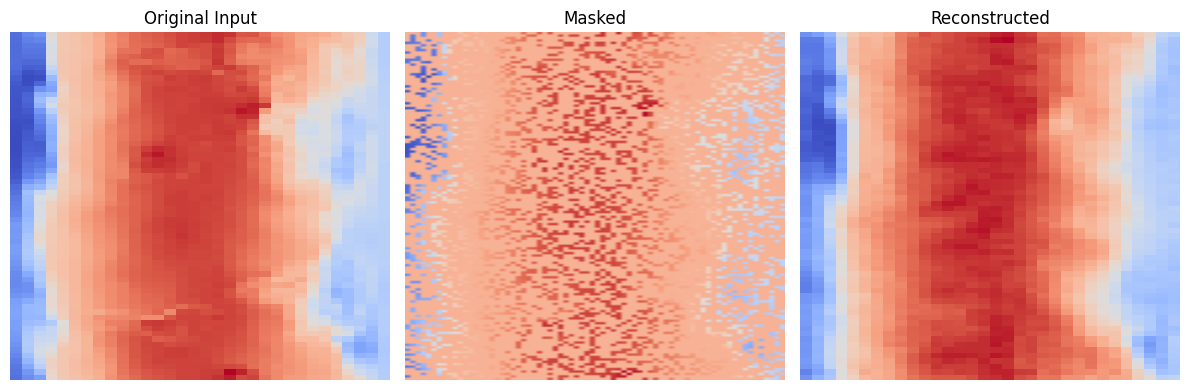

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_orig_temp, cmap="coolwarm", aspect="auto")
axs[0].set_title("Original Input")
axs[0].axis("off")

axs[1].imshow(masked_x_temp, cmap="coolwarm", aspect="auto")
axs[1].set_title("Masked")
axs[1].axis("off")

axs[2].imshow(recon_masked_x_temp, cmap="coolwarm", aspect="auto")
axs[2].set_title("Reconstructed")
axs[2].axis("off")

plt.tight_layout()
plt.show()